# mini-BERT Pretrain Project
한글 위키 데이터를 이용한 BERT 사전학습 프로젝트  

목차:  
Section 1. 설정 (config)  
Section 2. 함수 정의  
    - Section 2.1 EDA 함수  
    - Section 2.2 토크나이저  
    - Section 2.3 데이터 전처리  
    - Section 2.4 유틸리티 함수  
    - Section 2.5 모델 구현  
    - Section 2.6 Dataset & Dynamic Masking Collator  
    - Section 2.7 학습 및 검증 함수  
Section 3. EDA  
Section 3. Tokenizer & Dataset 준비  
Section 4. DataLoader 생성  
Section 5. 모델 초기화  
Section 6. 모델 학습 & 결과  
Section 7. 평가  
SEction 8. Abulation Study & 회고

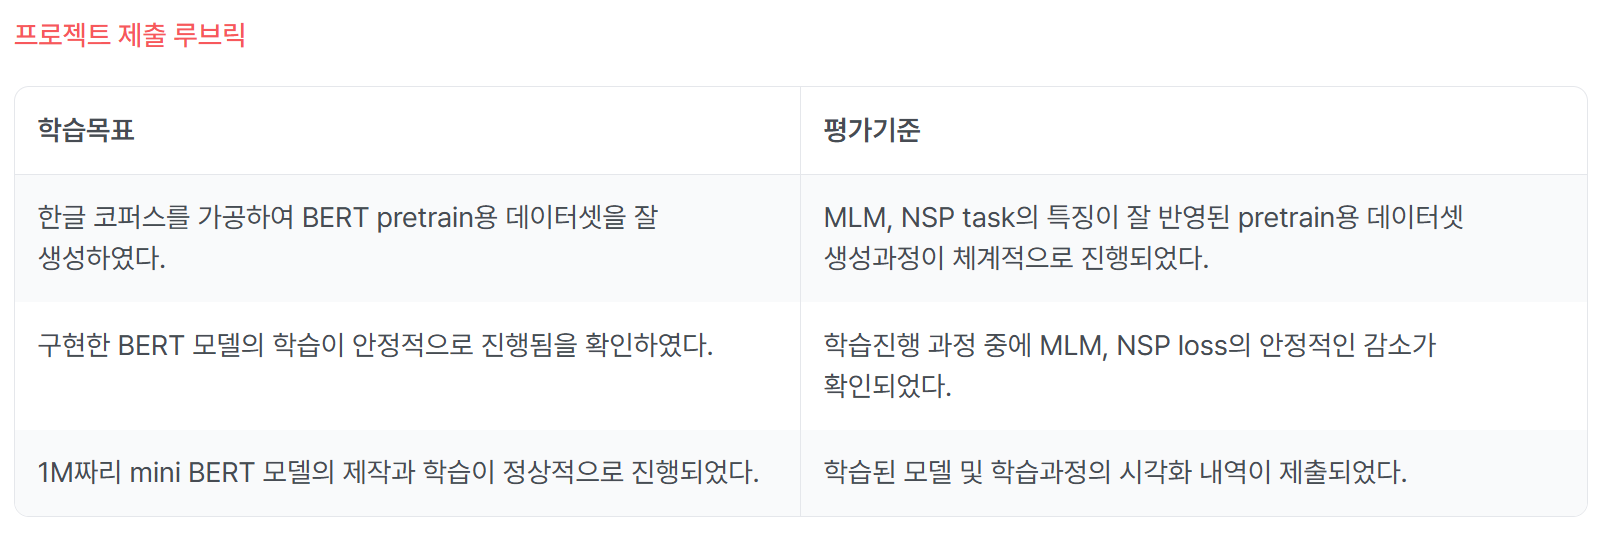

# Section 1. 설정 (config)
1. 라이브러리 로드
2. 시드 고정
3. cofig

In [1]:
!pip install sentencepiece

In [2]:
import os
import re
import json
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm import tqdm
import shutil
import time
import threading

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 설정
CONFIG = {
    # 경로 설정
    "data_dir": "data",
    "corpus_file": "data/kowiki.txt",
    "processed_file": "data/bert_pretrain.json",
    "cleaned_file": "data/kowiki_cleaned.txt",
    "result_file": "models/ablation_results.csv",
    "tokenizer_dir": "tokenizers",
    "model_dir": "models",
    "tokenizer_prefix": "tokenizers/ko_8000",

    # 모델 하이퍼파라미터
    "d_model": 64,
    "n_layers": 12,
    "n_heads": 4,
    "d_ff": 256,
    "dropout": 0.1,

    # 학습 설정
    "vocab_size": 8000,
    "max_len": 128,
    "mask_prob": 0.15,
    "batch_size": 64,
    "epochs": 10,
    "patience": 5,
    "learning_rate": 0.0005,
    "weight_decay": 0.01,
    "warmup_ratio": 0.05,
    "train_split": 0.9, 
    
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "use_amp": True 
}

# 디렉토리 생성
os.makedirs(CONFIG["data_dir"], exist_ok=True)
os.makedirs(CONFIG["tokenizer_dir"], exist_ok=True)
os.makedirs(CONFIG["model_dir"], exist_ok=True)

print(f"Device: {CONFIG['device']}")
print(f"Config: {json.dumps(CONFIG, indent=2, ensure_ascii=False)}")

Device: cuda
Config: {
  "data_dir": "data",
  "corpus_file": "data/kowiki.txt",
  "processed_file": "data/bert_pretrain.json",
  "cleaned_file": "data/kowiki_cleaned.txt",
  "result_file": "models/ablation_results.csv",
  "tokenizer_dir": "tokenizers",
  "model_dir": "models",
  "tokenizer_prefix": "tokenizers/ko_8000",
  "d_model": 64,
  "n_layers": 12,
  "n_heads": 4,
  "d_ff": 256,
  "dropout": 0.1,
  "vocab_size": 8000,
  "max_len": 128,
  "mask_prob": 0.15,
  "batch_size": 64,
  "epochs": 10,
  "patience": 5,
  "learning_rate": 0.0005,
  "weight_decay": 0.01,
  "warmup_ratio": 0.05,
  "train_split": 0.9,
  "device": "cuda",
  "use_amp": true
}


# Section 2. 함수 정의

## Section 2.1 토크나이저
1. SentencePiece 토크나이저 학습
2. 토크나이저 로드

In [4]:
def train_sentencepiece(corpus_file, prefix, target_vocab_size):
    """SentencePiece 모델 학습 (진행 상황 모니터링 추가)"""
    
    if os.path.exists(f"{prefix}.model"):
        print(f"토크나이저가 이미 존재합니다: {prefix}.model")
        return

    print(f"SentencePiece 토크나이저 학습 시작... (Target Vocab: {target_vocab_size})", flush=True)
    print("NOTE: 데이터 크기에 따라 수 분에서 수십 분이 걸릴 수 있습니다.", flush=True)

    # -----------------------------------------------------------
    # [추가됨] 학습이 도는 동안 1분마다 생존 신고를 하는 스레드
    # -----------------------------------------------------------
    stop_event = threading.Event()

    def print_alive():
        start_time = time.time()
        while not stop_event.is_set():
            time.sleep(60) # 60초 대기
            if stop_event.is_set(): break
            
            elapsed = int(time.time() - start_time)
            print(f"   ... 학습 진행 중 (경과 시간: {elapsed}초)", flush=True)

    # 스레드 시작
    t = threading.Thread(target=print_alive, daemon=True)
    t.start()

    # -----------------------------------------------------------
    # 학습 시작
    # -----------------------------------------------------------
    try:
        # 특수 토큰 7개를 제외한 순수 단어 개수 계산
        input_vocab_arg = target_vocab_size - 7

        spm.SentencePieceTrainer.train(
            input=corpus_file,
            model_prefix=prefix,
            vocab_size=input_vocab_arg,
            character_coverage=0.9995,
            model_type='bpe',
            pad_id=0, unk_id=1, bos_id=2, eos_id=3,
            user_defined_symbols=['[CLS]', '[SEP]', '[MASK]', '[PAD]'],
            input_sentence_size=10000000,
            shuffle_input_sentence=True
        )
    except Exception as e:
        print(f"\n[오류 발생] {e}")
        raise e
    finally:
        # 학습이 끝나거나 에러가 나면 스레드 종료
        stop_event.set()
        t.join()

    print("\n✅ 토크나이저 학습 완료!")
    
def load_tokenizer(model_path):
    sp = spm.SentencePieceProcessor()
    sp.load(model_path)
    return sp

## Section 2.2 데이터 전처리
1. 마스크 생성 (Whole Word Masking 적용)
2. 길이 초과 시 토큰 잘라내기
3. 문서별 pretrain 데이터 인스턴스 생성
4. 메인 전처리 함수
5. EDA

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성 (Whole Word Masking 적용)
    """
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        # SentencePiece의 언더바(_)로 시작하면 새로운 단어의 시작
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)
    mask_lms = []
    
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
            
        dice = random.random()
        for index in index_set:
            masked_token = None
            # 80% 확률로 [MASK]
            if dice < 0.8:
                masked_token = "[MASK]"
            # 10% 확률로 원본 유지
            elif dice < 0.9:
                masked_token = tokens[index]
            # 10% 확률로 랜덤 단어
            else:
                masked_token = random.choice(vocab_list)
                
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

def trim_tokens(tokens_a, tokens_b, max_seq):
    """길이 초과 시 토큰 잘라내기"""
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """문서별 pretrain 데이터 인스턴스 생성"""
    max_seq = n_seq - 3
    instances = []
    current_chunk = []
    current_length = 0
    
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            # SOP (Sentence Order Prediction)
            if random.random() < 0.5:
                is_next = 0 # 순서 바뀜 (False)
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1 # 순서 유지 (True)
            
            trim_tokens(tokens_a, tokens_b, max_seq)
            
            if len(tokens_a) == 0 or len(tokens_b) == 0:
                continue
                
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            
            # Masking 적용
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
            
    return instances

def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """메인 전처리 함수: 파일 읽기 -> 문장 분리 -> 인스턴스 생성 -> 저장"""
    
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 랜덤 마스킹용 Vocab List 생성 (특수 토큰 제외)
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # 라인 수 계산 (진행률 표시용)
    line_cnt = 0
    with open(in_file, "r", encoding='utf-8') as in_f:
        for _ in in_f: line_cnt += 1

    print(f"데이터 생성 시작: {in_file} -> {out_file}")
    
    with open(in_file, "r", encoding='utf-8') as in_f:
        with open(out_file, "w", encoding='utf-8') as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt, desc="Preprocessing"):
                line = line.strip()
                
                # 빈 줄은 문서의 경계로 인식
                if line == "":
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:
                    # KSS 문장 분리 적용
                    try:
                        sentences = kss.split_sentences(line)
                    except:
                        sentences = [line]

                    for sent in sentences:
                        pieces = vocab.encode_as_pieces(sent)
                        if len(pieces) > 0:
                            doc.append(pieces)
                            
            if len(doc) > 0:
                save_pretrain_instances(out_f, doc)

    print("전처리 완료")

In [6]:
class TransformerEncoderLayer(nn.Module):
    """Pre-LayerNorm Transformer Encoder Layer"""
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        norm_x = self.norm1(x)
        attn_output = self.attention(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout1(attn_output)
        
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout2(ff_output)
        
        return x

class BERTEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position_emb = nn.Embedding(max_len, d_model)
        self.segment_emb = nn.Embedding(2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids):
        batch_size, seq_len = x.size()
        pos = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        embedding = self.token_emb(x) + self.position_emb(pos) + self.segment_emb(segment_ids)
        return self.dropout(self.norm(embedding))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        Q = self.W_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e4)
        attn = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(gelu(self.linear1(x))))

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.embedding = BERTEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        # Pre-LayerNorm의 경우 마지막에 Norm 추가가 일반적
        self.final_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, segment_ids, mask):
        x = self.embedding(x, segment_ids)
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_norm(x)

class BERTForPretraining(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.bert = BERT(vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )
        self.nsp_head = nn.Linear(d_model, 2)
        
    def forward(self, input_ids, segment_ids, attention_mask):
        encoded = self.bert(input_ids, segment_ids, attention_mask)
        mlm_logits = self.mlm_head(encoded)
        nsp_logits = self.nsp_head(encoded[:, 0])
        return mlm_logits, nsp_logits

## Section 2.3 Dataset & Dynamic Masking Collator
1. Pretrain 데이터 생성 / 로드
2. 이미 마스킹된 데이터셋의 배치를 받아 패딩(Padding)을 수행

In [7]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """
    KSS 대신 정규표현식을 사용하여 속도를 획기적으로 개선한 버전
    """
    
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 1. 특수문자 제외 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # 2. 라인 수 확인
    line_cnt = 0
    with open(in_file, "r", encoding='utf-8') as in_f:
        for _ in in_f: line_cnt += 1

    print(f"데이터 생성 시작 (Regex 문장 분리 적용): {in_file} -> {out_file}")
    
    # 3. 정규표현식 컴파일 (속도 최적화)
    # 문장의 끝(. ? !) 뒤에 공백이 오면 자릅니다.
    splitter = re.compile(r'(?<=[.?!])\s+')

    with open(in_file, "r", encoding='utf-8') as in_f:
        with open(out_file, "w", encoding='utf-8') as out_f:
            doc = []
            
            for line in tqdm(in_f, total=line_cnt, desc="Preprocessing"):
                line = line.strip()
                
                # [문서 구분] 빈 줄
                if line == "":
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                
                # [문장 처리] 내용이 있는 줄
                else:
                    # ★★★ [수정됨] KSS -> Regex ★★★
                    # 단순하고 빠른 규칙 기반 분리 사용
                    sentences = splitter.split(line)

                    for sent in sentences:
                        sent = sent.strip()
                        if len(sent) < 2: continue # 너무 짧은 문장은 노이즈로 간주하고 제거

                        pieces = vocab.encode_as_pieces(sent)
                        if len(pieces) > 0:
                            doc.append(pieces)
            
            if len(doc) > 0:
                save_pretrain_instances(out_f, doc)

    print("전처리 완료")

class PretrainDataset(Dataset):
    """
    전처리된 JSON 파일을 로드하여 학습 데이터셋으로 변환하는 클래스
    """
    def __init__(self, path, vocab):
        self.vocab = vocab
        self.data = []
        
        print(f"데이터셋 로드 중: {path}")
        # 파일이 존재하는지 확인
        if not os.path.exists(path):
            raise FileNotFoundError(f"파일을 찾을 수 없습니다: {path}")

        with open(path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading JSON"):
                try:
                    self.data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue # 깨진 라인은 무시
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        item = self.data[i]
        
        # Token Strings -> Token IDs 변환
        input_ids = [self.vocab.piece_to_id(p) for p in item["tokens"]]
        segment_ids = item["segment"]
        
        # MLM Labels 생성
        # 전체를 -100(Loss 계산 제외)으로 채우고, 마스킹된 위치만 정답 ID로 채움
        mlm_labels = [-100] * len(input_ids)
        for idx, label_str in zip(item["mask_idx"], item["mask_label"]):
            # label_str이 토크나이저에 없는 경우 대비
            label_id = self.vocab.piece_to_id(label_str)
            mlm_labels[idx] = label_id
            
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "segment_ids": torch.tensor(segment_ids, dtype=torch.long),
            "mlm_labels": torch.tensor(mlm_labels, dtype=torch.long),
            "nsp_label": torch.tensor(item["is_next"], dtype=torch.long)
        }

class StaticDataCollator:
    """
    이미 마스킹된 데이터셋의 배치를 받아 패딩(Padding)을 수행합니다.
    """
    def __init__(self, pad_id):
        self.pad_id = pad_id

    def __call__(self, batch):
        # 가장 긴 시퀀스 길이 찾기
        max_len = max([len(b["input_ids"]) for b in batch])
        
        input_ids_batch = []
        segment_ids_batch = []
        mlm_labels_batch = []
        nsp_labels_batch = []
        attention_mask_batch = []
        
        for b in batch:
            input_ids = b["input_ids"]
            segment_ids = b["segment_ids"]
            mlm_labels = b["mlm_labels"]
            
            pad_len = max_len - len(input_ids)
            
            # Padding 적용
            input_ids = F.pad(input_ids, (0, pad_len), value=self.pad_id)
            segment_ids = F.pad(segment_ids, (0, pad_len), value=0)
            mlm_labels = F.pad(mlm_labels, (0, pad_len), value=-100)
            
            # Attention Mask (Padding 부분은 0)
            attention_mask = (input_ids != self.pad_id).long()
            
            input_ids_batch.append(input_ids)
            segment_ids_batch.append(segment_ids)
            mlm_labels_batch.append(mlm_labels)
            attention_mask_batch.append(attention_mask)
            nsp_labels_batch.append(b["nsp_label"])
            
        return {
            "input_ids": torch.stack(input_ids_batch),
            "segment_ids": torch.stack(segment_ids_batch),
            "mlm_labels": torch.stack(mlm_labels_batch),
            "attention_mask": torch.stack(attention_mask_batch),
            "nsp_labels": torch.stack(nsp_labels_batch)
        }

## Section 2.4 모델 구현
1. GeLU
2. Multi-Head Attention
3. Feed-Forward Network
4. Transformer Encoder Layer
5. BERT Model
6. BERT for Pretraining

In [8]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / np.sqrt(2.0)))

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        Q = self.W_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            # AMP 안전장치: -1e9 대신 -1e4 사용
            scores = scores.masked_fill(mask == 0, -1e4)
            
        attn = self.dropout(F.softmax(scores, dim=-1))
        context = torch.matmul(attn, V).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.linear2(self.dropout(gelu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    def forward(self, x, mask):
        x = x + self.dropout1(self.attention(self.norm1(x), self.norm1(x), self.norm1(x), mask))
        x = x + self.dropout2(self.feed_forward(self.norm2(x)))
        return x

class BERT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position_emb = nn.Embedding(max_len, d_model)
        self.segment_emb = nn.Embedding(2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.final_norm = nn.LayerNorm(d_model)
    def forward(self, x, segment_ids, mask):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x = self.dropout(self.norm(self.token_emb(x) + self.position_emb(pos) + self.segment_emb(segment_ids)))
        for layer in self.layers:
            x = layer(x, mask)
        return self.final_norm(x)

class BERTForPretraining(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout):
        super().__init__()
        self.bert = BERT(vocab_size, d_model, n_layers, n_heads, d_ff, max_len, dropout)
        
        # MLM Head (구조 변경: Sequential -> 개별 정의)
        self.mlm_dense = nn.Linear(d_model, d_model)
        self.mlm_act = nn.GELU()
        self.mlm_norm = nn.LayerNorm(d_model)
        
        # [핵심] 출력 레이어 (Bias는 별도로 둠)
        self.mlm_decoder = nn.Linear(d_model, vocab_size, bias=True)
        
        # NSP Head
        self.nsp_head = nn.Linear(d_model, 2)
        
        # =========================================================
        # Weight Tying (가중치 공유) 적용
        # 입력 임베딩과 출력 레이어의 가중치를 동일하게 묶습니다.
        # 파라미터 수를 절약하는 효과가 있습니다.
        # =========================================================
        self.mlm_decoder.weight = self.bert.token_emb.weight

    def forward(self, input_ids, segment_ids, attention_mask):
        # BERT Encoding
        encoded = self.bert(input_ids, segment_ids, attention_mask)
        
        # MLM Head Forward
        x = self.mlm_dense(encoded)
        x = self.mlm_act(x)
        x = self.mlm_norm(x)
        mlm_logits = self.mlm_decoder(x) # 공유된 가중치 사용
        
        # NSP Head Forward
        nsp_logits = self.nsp_head(encoded[:, 0])
        
        return mlm_logits, nsp_logits

## Section 2.5 학습 유틸리티 및 루프
1. 파라미터 개수 계산
2. 조기 종료
3. 학습
4. 검증
5. 결과 저장
6. Model manager

In [9]:
# 파라미터 개수 count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

class EarlyStopping:
    def __init__(self, patience=3, verbose=True, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_epoch(model, dataloader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
        mlm_labels = batch['mlm_labels'].to(device)
        nsp_labels = batch['nsp_labels'].to(device)
        
        with autocast(enabled=CONFIG["use_amp"]):
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            loss = mlm_loss + nsp_loss
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    mlm_correct = mlm_total = 0
    nsp_correct = nsp_total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            segment_ids = batch['segment_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device).unsqueeze(1).unsqueeze(2)
            mlm_labels = batch['mlm_labels'].to(device)
            nsp_labels = batch['nsp_labels'].to(device)
            
            mlm_logits, nsp_logits = model(input_ids, segment_ids, attention_mask)
            
            # Loss
            mlm_loss = F.cross_entropy(mlm_logits.view(-1, CONFIG['vocab_size']), mlm_labels.view(-1), ignore_index=-100)
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            total_loss += (mlm_loss + nsp_loss).item()
            
            # Accuracy
            mlm_preds = mlm_logits.argmax(dim=-1)
            mask_indices = (mlm_labels != -100)
            mlm_correct += (mlm_preds[mask_indices] == mlm_labels[mask_indices]).sum().item()
            mlm_total += mask_indices.sum().item()
            
            nsp_correct += (nsp_logits.argmax(dim=-1) == nsp_labels).sum().item()
            nsp_total += len(nsp_labels)
            
    avg_loss = total_loss / len(dataloader)
    mlm_acc = mlm_correct / max(1, mlm_total)
    nsp_acc = nsp_correct / max(1, nsp_total)
    
    return avg_loss, mlm_acc, nsp_acc

def save_experiment_result(config, val_loss, mlm_acc, nsp_acc, file_path="models/ablation_results.csv"):
    """
    모든 실험의 하이퍼파라미터와 결과를 CSV 파일 하나에 누적하여 기록하는 함수
    """
    columns = [
        'ID', 'Exp_Name', 'd_model', 'n_layers', 'n_heads', 'batch_size', 
        'lr', 'epochs', 'Val_Loss', 'MLM_Acc', 'NSP_Acc'
    ]
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        next_id = df['ID'].max() + 1 if not df.empty else 1
    else:
        df = pd.DataFrame(columns=columns)
        next_id = 1
        
    new_data = {
        'ID': next_id,
        'Exp_Name': config.get('exp_name', 'Unknown'), # 실험 이름 추가
        'd_model': config['d_model'],
        'n_layers': config['n_layers'],
        'n_heads': config['n_heads'],
        'batch_size': config['batch_size'],
        'lr': config['learning_rate'],
        'epochs': config['epochs'],
        'Val_Loss': round(val_loss, 4),
        'MLM_Acc': round(mlm_acc, 4),
        'NSP_Acc': round(nsp_acc, 4)
    }
    
    new_df = pd.DataFrame([new_data])
    final_df = pd.concat([df, new_df], ignore_index=True)
    final_df.to_csv(file_path, index=False)
    
    print(f"\n[실험 결과 기록 완료] {file_path}")
    print(final_df.tail(1).to_string(index=False))

    
class ModelManager:
    def __init__(self, config, exp_name=None):
        """
        Args:
            config: 학습 설정 딕셔너리
            exp_name: 실험 이름 (없으면 'bert_D{d_model}_L{n_layers}' 자동 생성)
        """
        self.config = config
        
        # 실험 이름 자동 생성 (예: bert_D256_L6_B128)
        if exp_name is None:
            exp_name = f"bert_D{config['d_model']}_L{config['n_layers']}_B{config['batch_size']}"
        
        self.save_dir = os.path.join(config["model_dir"], exp_name)
        os.makedirs(self.save_dir, exist_ok=True)
        
        # Config 저장 (나중에 모델 구조 확인할 때 필수)
        with open(os.path.join(self.save_dir, "config.json"), 'w', encoding='utf-8') as f:
            json.dump(config, f, indent=4, ensure_ascii=False)
            
        print(f"📁 실험 폴더: {self.save_dir}")

    def save_best_model(self, model, score):
        """가장 성능 좋은 모델 저장 (가중치만, 가벼움)"""
        path = os.path.join(self.save_dir, "best_model.pt")
        torch.save(model.state_dict(), path)
        print(f"⭐ Best Model 갱신 (Loss: {score:.4f}) -> {path}")

    def save_checkpoint(self, epoch, model, optimizer, scheduler, scaler, val_loss):
        """학습 중단 대비용 체크포인트 (항상 덮어쓰기)"""
        path = os.path.join(self.save_dir, "last_checkpoint.pt")
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'scaler_state': scaler.state_dict(),
            'val_loss': val_loss,
            'config': self.config
        }, path)

    def load_checkpoint(self, model, optimizer, scheduler, scaler):
        """체크포인트가 있으면 로드, 없으면 0 리턴"""
        path = os.path.join(self.save_dir, "last_checkpoint.pt")
        if not os.path.exists(path):
            return 0 # 처음부터 시작
            
        print(f"🔄 학습 재개: {path}")
        checkpoint = torch.load(path)
        
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        scheduler.load_state_dict(checkpoint['scheduler_state'])
        scaler.load_state_dict(checkpoint['scaler_state'])
        
        return checkpoint['epoch'] + 1

## Section 2.6 평가
1. MLM 평가 (빈칸 채우기) - 문장 중간에 [MASK]를 넣었을 때, 모델이 이를 어떤 단어로 예측하는지 확인
2. NSP 평가 (다음 문장 예측) - 두 문장(A, B)을 주고, B가 A 다음에 오는 것이 자연스러운지(IsNext) 판단

In [10]:
def predict_mask(text, model, tokenizer, device, top_k=5):
    """
    입력 문장의 [MASK] 위치에 들어갈 단어 Top-K 예측
    """
    model.eval()
    
    # 1. 토큰화
    tokens = tokenizer.encode_as_pieces(text)
    token_ids = tokenizer.encode_as_ids(text)
    
    # 2. [MASK] 위치 찾기
    try:
        mask_idx = tokens.index("[MASK]")
    except ValueError:
        print(f"오류: 입력 문장에 '[MASK]' 토큰이 없습니다. -> {text}")
        return

    # 3. 텐서 변환 (Batch Size = 1)
    input_ids = torch.tensor([token_ids], device=device)
    segment_ids = torch.zeros_like(input_ids, device=device)
    attention_mask = torch.ones_like(input_ids, device=device).unsqueeze(1).unsqueeze(2)

    # 4. 모델 예측
    with torch.no_grad():
        mlm_logits, _ = model(input_ids, segment_ids, attention_mask)
    
    # 5. [MASK] 위치의 예측값 가져오기
    mask_logits = mlm_logits[0, mask_idx]
    topk_prob, topk_indices = torch.topk(F.softmax(mask_logits, dim=-1), top_k)
    
    # 6. 결과 출력
    print(f"\n[입력] {text}")
    print(f"[정답 후보]")
    for i in range(top_k):
        token = tokenizer.id_to_piece(topk_indices[i].item())
        prob = topk_prob[i].item() * 100
        print(f"  {i+1}위: {token} ({prob:.2f}%)")


def predict_next_sentence(sent_a, sent_b, model, tokenizer, device):
    """
    두 문장이 이어지는지(IsNext) 확률 예측
    """
    model.eval()
    
    # 1. 입력 포맷 만들기: [CLS] A [SEP] B [SEP]
    tokens_a = tokenizer.encode_as_ids(sent_a)
    tokens_b = tokenizer.encode_as_ids(sent_b)
    
    input_ids = [tokenizer.piece_to_id("[CLS]")] + tokens_a + \
                [tokenizer.piece_to_id("[SEP]")] + tokens_b + \
                [tokenizer.piece_to_id("[SEP]")]
    
    # 2. Segment ID (A=0, B=1)
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
    
    # 3. 텐서 변환
    input_tensor = torch.tensor([input_ids], device=device)
    segment_tensor = torch.tensor([segment_ids], device=device)
    mask_tensor = torch.ones_like(input_tensor, device=device).unsqueeze(1).unsqueeze(2)
    
    # 4. 모델 예측
    with torch.no_grad():
        _, nsp_logits = model(input_tensor, segment_tensor, mask_tensor)
    
    # 5. 확률 계산 (Softmax)
    probs = F.softmax(nsp_logits, dim=-1)
    # nsp_head의 출력: [NotNext, IsNext] 순서인지 [IsNext, NotNext] 순서인지 확인 필요
    # 보통 학습 데이터 라벨이 (IsNext=1, NotNext=0) 이었으면 index 1이 IsNext
    # 현재 코드의 SOP 방식: 1=순서맞음(IsNext), 0=순서바뀜(NotNext)
    
    score = probs[0, 1].item() * 100  # Index 1이 True(연결됨)일 확률
    
    print(f"\n[문장 A] {sent_a}")
    print(f"[문장 B] {sent_b}")
    print(f"▶️ 이어지는 문장일 확률: {score:.2f}%")
    if score > 50:
        print("   => 결과: 자연스러운 연결 (True)")
    else:
        print("   => 결과: 부자연스러운 연결 (False)")

# Section 3. Tokenizer & Dataset 준비

In [11]:
# 실험 이름 (None으로 두면 파라미터 조합으로 자동 생성됨)
# EXP_NAME = f"MiniBERT_L{CONFIG['n_layers']}_D{CONFIG['d_model']}_B{CONFIG['batch_size']}"
EXP_NAME = f"MiniBERT_L{CONFIG['n_layers']}_V{CONFIG['vocab_size']}_D{CONFIG['d_model']}_Weight_Tying"
# EXP_NAME = "MiniBERT_L12_D64_B64"
CONFIG['exp_name'] = EXP_NAME # CSV 기록용으로 Config에 이름 추가

# ------------------------------------------------------------------
# 1. 매니저 초기화 & 재개 설정
# ------------------------------------------------------------------
# 매니저 초기화 (폴더 생성 및 Config 저장 자동 수행)
manager = ModelManager(CONFIG, exp_name=EXP_NAME)

📁 실험 폴더: models/MiniBERT_L12_V8000_D64_Weight_Tying


In [12]:
# 토크나이저 학습/로드
if not os.path.exists(f"{CONFIG['tokenizer_prefix']}.model"):
    train_sentencepiece(CONFIG["corpus_file"], CONFIG["tokenizer_prefix"], CONFIG["vocab_size"])

tokenizer = load_tokenizer(f"{CONFIG['tokenizer_prefix']}.model")

# 실제 토크나이저 크기와 Config 설정값이 다르면 에러가 발생하므로 맞춰줍니다.
actual_vocab_size = tokenizer.get_piece_size()
if CONFIG["vocab_size"] != actual_vocab_size:
    print(f"⚠️ Vocab Size 자동 수정: {CONFIG['vocab_size']} -> {actual_vocab_size} (특수 토큰 포함)")
    CONFIG["vocab_size"] = actual_vocab_size

⚠️ Vocab Size 자동 수정: 8000 -> 8007 (특수 토큰 포함)


In [13]:
# 전처리 파일 로드
if not os.path.exists(CONFIG["processed_file"]):
    make_pretrain_data(
        tokenizer, 
        CONFIG["corpus_file"], 
        CONFIG["processed_file"], 
        CONFIG["max_len"], 
        CONFIG["mask_prob"]
    )
else:
    print(f"기존 전처리 파일 사용: {CONFIG['processed_file']}")
    
# Dataset 인스턴스 생성
full_dataset = PretrainDataset(CONFIG["processed_file"], tokenizer)

# Train/Val 분할
train_size = int(len(full_dataset) * CONFIG["train_split"])
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

print(f"학습 데이터: {len(train_set):,}개 | 검증 데이터: {len(val_set):,}개")

기존 전처리 파일 사용: data/bert_pretrain.json
데이터셋 로드 중: data/bert_pretrain.json


Loading JSON: 1294382it [01:25, 15099.33it/s]


학습 데이터: 1,164,943개 | 검증 데이터: 129,439개


# Section 4. DataLoader 생성

In [14]:
collator = StaticDataCollator(pad_id=0)

# drop_last=True: 마지막 배치가 batch_size보다 작을 때 발생하는 형태 불일치 에러 방지
train_loader = DataLoader(
    train_set, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    collate_fn=collator, 
    drop_last=True,
    # num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_set, 
    batch_size=CONFIG["batch_size"], 
    shuffle=False, 
    collate_fn=collator, 
    drop_last=True,
    # num_workers=4,
    pin_memory=True
)
print(f"Train Batches: {len(train_loader)}")
print(f"Val Batches:   {len(val_loader)}")
print("DataLoader 생성 완료!")

Train Batches: 18202
Val Batches:   2022
DataLoader 생성 완료!


# Section 5. 모델 초기화

In [15]:
model = BERTForPretraining(
    CONFIG["vocab_size"], 
    CONFIG["d_model"], 
    CONFIG["n_layers"], 
    CONFIG["n_heads"], 
    CONFIG["d_ff"], 
    CONFIG["max_len"], 
    CONFIG["dropout"]
).to(CONFIG["device"])

print(f"전체 파라미터 수: {count_parameters(model):,}")
print(f"디바이스: {CONFIG["device"]}")

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG["learning_rate"],
    weight_decay=CONFIG["weight_decay"]
)

scaler = torch.amp.GradScaler(
    'cuda', 
    enabled=CONFIG["use_amp"]
)

# Warmup Steps 자동 계산
# 전체 학습 스텝 = (한 에포크 당 배치 수) * (총 에포크 수)
total_steps = len(train_loader) * CONFIG["epochs"]

# 웜업 스텝 = 전체 스텝의 5% (설정값)
CONFIG["warmup_steps"] = int(total_steps * CONFIG.get("warmup_ratio", 0.05))

print(f"✅ 학습 설정 확인:")
print(f"   - 총 학습 스텝 (Total Steps): {total_steps:,}")
print(f"   - 웜업 스텝 (Warmup Steps): {CONFIG['warmup_steps']:,} (비율: {CONFIG.get('warmup_ratio')*100}%)")
print(f"   - 배치 사이즈: {CONFIG['batch_size']}")
print(f"   - 학습률: {CONFIG['learning_rate']}")

# 스케줄러 설정
# LinearLR: 시작 LR(0.1배)에서 웜업 기간 동안 목표 LR(1.0배)까지 선형 증가
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 
    start_factor=0.1, 
    total_iters=CONFIG["warmup_steps"]
)

early_stopping = EarlyStopping(
    patience=CONFIG["patience"], 
    verbose=True, 
    path=f"{manager.save_dir}/best_model.pt"
)

전체 파라미터 수: 1,133,257
디바이스: cuda
✅ 학습 설정 확인:
   - 총 학습 스텝 (Total Steps): 182,020
   - 웜업 스텝 (Warmup Steps): 9,101 (비율: 5.0%)
   - 배치 사이즈: 64
   - 학습률: 0.0005


# Section 6. 모델 학습 & 결과

학습 재개: Epoch 1부터 시작

학습 시작 (Epochs: 10)

Epoch 1/10


Training:   0%|          | 0/18202 [00:00<?, ?it/s]/tmp/ipykernel_1820/794310241.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=CONFIG["use_amp"]):
/opt/conda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Validation: 100%|██████████| 2022/2022 [01:29<00:00, 22.66it/s]


Train Loss: 8.3695 | Val Loss: 7.2477
MLM Acc: 0.1301 | NSP Acc: 0.6996
⭐ Best Model 갱신 (Loss: 7.2477) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (inf --> 7.247685). Saving model...

Epoch 2/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.06it/s]


Train Loss: 7.0575 | Val Loss: 6.7032
MLM Acc: 0.1463 | NSP Acc: 0.7202
⭐ Best Model 갱신 (Loss: 6.7032) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (7.247685 --> 6.703227). Saving model...

Epoch 3/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.15it/s]


Train Loss: 6.3182 | Val Loss: 5.8003
MLM Acc: 0.1884 | NSP Acc: 0.7237
⭐ Best Model 갱신 (Loss: 5.8003) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (6.703227 --> 5.800303). Saving model...

Epoch 4/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.17it/s]


Train Loss: 5.7313 | Val Loss: 5.3856
MLM Acc: 0.2205 | NSP Acc: 0.7310
⭐ Best Model 갱신 (Loss: 5.3856) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (5.800303 --> 5.385621). Saving model...

Epoch 5/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.13it/s]


Train Loss: 5.4309 | Val Loss: 5.1674
MLM Acc: 0.2417 | NSP Acc: 0.7338
⭐ Best Model 갱신 (Loss: 5.1674) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (5.385621 --> 5.167378). Saving model...

Epoch 6/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.10it/s]


Train Loss: 5.2579 | Val Loss: 5.0390
MLM Acc: 0.2533 | NSP Acc: 0.7367
⭐ Best Model 갱신 (Loss: 5.0390) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (5.167378 --> 5.038973). Saving model...

Epoch 7/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.17it/s]


Train Loss: 5.1486 | Val Loss: 4.9475
MLM Acc: 0.2617 | NSP Acc: 0.7387
⭐ Best Model 갱신 (Loss: 4.9475) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (5.038973 --> 4.947518). Saving model...

Epoch 8/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.14it/s]


Train Loss: 5.0715 | Val Loss: 4.8911
MLM Acc: 0.2674 | NSP Acc: 0.7306
⭐ Best Model 갱신 (Loss: 4.8911) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (4.947518 --> 4.891092). Saving model...

Epoch 9/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.19it/s]


Train Loss: 5.0130 | Val Loss: 4.8360
MLM Acc: 0.2730 | NSP Acc: 0.7358
⭐ Best Model 갱신 (Loss: 4.8360) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (4.891092 --> 4.835954). Saving model...

Epoch 10/10


Validation: 100%|██████████| 2022/2022 [01:27<00:00, 23.06it/s]


Train Loss: 4.9676 | Val Loss: 4.7897
MLM Acc: 0.2779 | NSP Acc: 0.7414
⭐ Best Model 갱신 (Loss: 4.7897) -> models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt
Validation loss decreased (4.835954 --> 4.789677). Saving model...

[실험 결과 기록 완료] models/ablation_results.csv
 ID  d_model  n_layers  n_heads  d_ff  dropout  vocab_size  max_len  mask_prob  batch_size  epochs  learning_rate  weight_decay  warmup_ratio  Val_Loss  MLM_Acc  NSP_Acc                            Exp_Name     lr
  4       64        12        4   NaN      NaN         NaN      NaN        NaN          64      10            NaN           NaN           NaN    4.7897   0.2779   0.7414 MiniBERT_L12_V8000_D64_Weight_Tying 0.0005
학습 완료. 결과 파일: models/MiniBERT_L12_V8000_D64_Weight_Tying


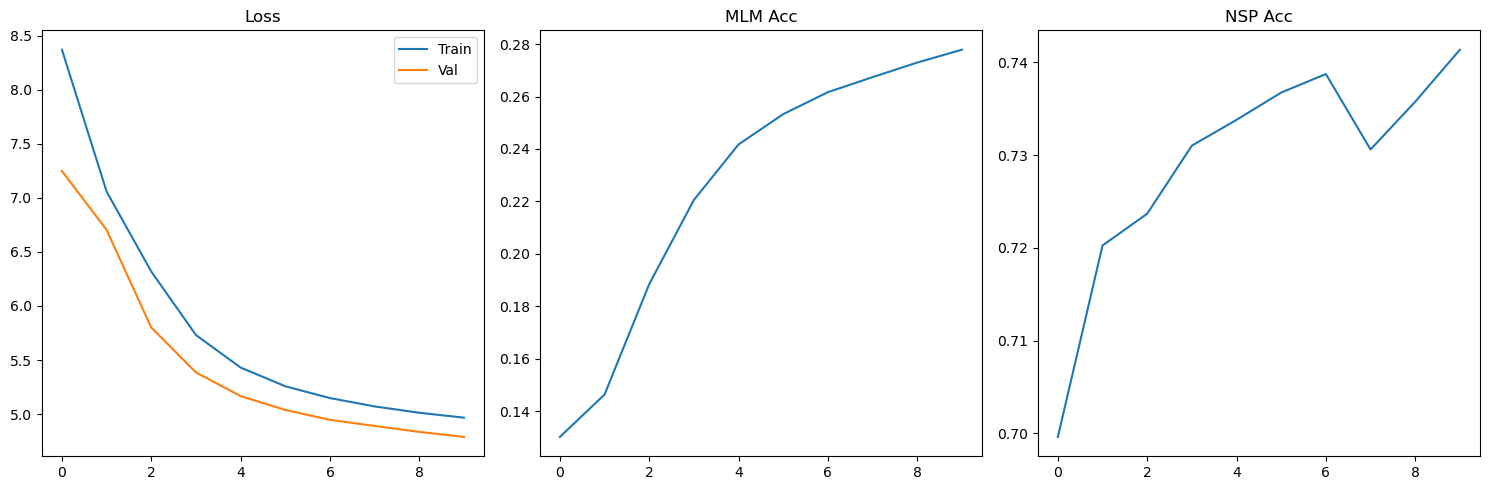

In [16]:
# [설정] True면 중단된 곳부터 이어서, False면 싹 지우고 처음부터
# RESUME_TRAINING = False  
RESUME_TRAINING = True

start_epoch = 0
best_val_loss = float('inf')
best_mlm_acc = 0
best_nsp_acc = 0

# 2. 학습 재개 여부 확인
if RESUME_TRAINING:
    start_epoch = manager.load_checkpoint(model, optimizer, scheduler, scaler)
    print(f"학습 재개: Epoch {start_epoch+1}부터 시작")
else:
    print("새로운 학습 시작")

print(f"\n학습 시작 (Epochs: {CONFIG['epochs']})")

history = {'train_loss': [], 'val_loss': [], 'mlm_acc': [], 'nsp_acc': []}

for epoch in range(start_epoch, CONFIG["epochs"]):
    print(f"\nEpoch {epoch + 1}/{CONFIG['epochs']}")
    
    # Train & Val
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, CONFIG["device"])
    val_loss, mlm_acc, nsp_acc = validate_epoch(model, val_loader, CONFIG["device"])
    
    # 기록
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mlm_acc'].append(mlm_acc)
    history['nsp_acc'].append(nsp_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MLM Acc: {mlm_acc:.4f} | NSP Acc: {nsp_acc:.4f}")
    
    # [저장 1] Best Model 갱신 시 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_mlm_acc = mlm_acc
        best_nsp_acc = nsp_acc
        manager.save_best_model(model, val_loss)
    
    # [저장 2] Checkpoint 매번 저장 (Resume용)
    manager.save_checkpoint(epoch, model, optimizer, scheduler, scaler, val_loss)
    
    # Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 3. 학습 종료 후 결과 요약 저장 (CSV)
save_experiment_result(
    CONFIG, 
    best_val_loss, 
    best_mlm_acc, 
    best_nsp_acc,
    file_path=CONFIG["result_file"]
)

# 4. 그래프 저장
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.legend(); plt.title('Loss')
plt.subplot(1, 3, 2); plt.plot(history['mlm_acc']); plt.title('MLM Acc')
plt.subplot(1, 3, 3); plt.plot(history['nsp_acc']); plt.title('NSP Acc')
plt.tight_layout()
plt.savefig(os.path.join(manager.save_dir, "history.png"))
print(f"학습 완료. 결과 파일: {manager.save_dir}")

# Section 7. 평가

In [17]:
# 1. 토크나이저 및 설정 로드
tokenizer = load_tokenizer(f"{CONFIG['tokenizer_prefix']}.model")
vocab_size = tokenizer.get_piece_size()

# 2. 모델 구조 생성 (학습 때와 동일한 설정)
model = BERTForPretraining(
    vocab_size=vocab_size,
    d_model=CONFIG["d_model"],
    n_layers=CONFIG["n_layers"],
    n_heads=CONFIG["n_heads"],
    d_ff=CONFIG["d_ff"],
    max_len=CONFIG["max_len"],
    dropout=CONFIG["dropout"]
).to(CONFIG["device"])

# 3. 학습된 가중치(Best Model) 로드
model_path = f"{manager.save_dir}/best_model.pt"

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=CONFIG["device"]))
    print(f"✅ 모델 로드 성공: {model_path}")
else:
    print("⚠️ 모델 파일이 없습니다. 경로를 확인하세요.")

model.eval()  # 평가 모드 전환 (Dropout 끔)

✅ 모델 로드 성공: models/MiniBERT_L12_V8000_D64_Weight_Tying/best_model.pt


BERTForPretraining(
  (bert): BERT(
    (token_emb): Embedding(8007, 64, padding_idx=0)
    (position_emb): Embedding(128, 64)
    (segment_emb): Embedding(2, 64)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (attention): MultiHeadAttention(
          (W_q): Linear(in_features=64, out_features=64, bias=True)
          (W_k): Linear(in_features=64, out_features=64, bias=True)
          (W_v): Linear(in_features=64, out_features=64, bias=True)
          (W_o): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((64,), eps=1

In [18]:
# MLM 테스트
print("=== Masked Language Model (MLM) Test ===")

# (1) 일반 상식
predict_mask("대한민국의 수도는 [MASK]이다.", model, tokenizer, CONFIG["device"])

# (2) 위키피디아 스타일 (역사)
predict_mask("이순신 장군은 [MASK]시대의 무신이다.", model, tokenizer, CONFIG["device"])

# (3) 문맥 파악 (과학/수학)
predict_mask("지구는 태양 주위를 [MASK]한다.", model, tokenizer, CONFIG["device"])
predict_mask("1 더하기 1은 [MASK]이다.", model, tokenizer, CONFIG["device"])

=== Masked Language Model (MLM) Test ===

[입력] 대한민국의 수도는 [MASK]이다.
[정답 후보]
  1위: ▁사람 (20.24%)
  2위: 의 (18.73%)
  3위: ▁다음 (4.43%)
  4위: ▁뜻은 (3.05%)
  5위: 을 (2.82%)

[입력] 이순신 장군은 [MASK]시대의 무신이다.
[정답 후보]
  1위: ▁또는 (10.00%)
  2위: ▁있는 (6.91%)
  3위: 는 (5.65%)
  4위: ▁한국의 (5.32%)
  5위: ▁있었던 (4.08%)

[입력] 지구는 태양 주위를 [MASK]한다.
[정답 후보]
  1위: ▁것을 (9.64%)
  2위: ▁것으로 (5.34%)
  3위: ▁사람을 (5.27%)
  4위: ▁높이 (5.11%)
  5위: 어 (4.23%)

[입력] 1 더하기 1은 [MASK]이다.
[정답 후보]
  1위: ▁뜻은 (10.26%)
  2위: ▁사람 (8.28%)
  3위: ▁다음 (4.93%)
  4위: 의 (4.68%)
  5위: [UNK] (4.21%)


In [19]:
# NSP 테스트 실행
print("\n=== Next Sentence Prediction (NSP) Test ===")

# (1) 진짜 이어지는 문장 (True Case)
predict_next_sentence(
    "지미 카터는 미국의 제39대 대통령이다.", 
    "그는 퇴임 후에도 평화 전도사로 활동했다.", 
    model, tokenizer, CONFIG["device"]
)

# (2) 전혀 상관없는 문장 (False Case)
predict_next_sentence(
    "지미 카터는 미국의 제39대 대통령이다.", 
    "수학에서 상수는 변하지 않는 값을 의미한다.", 
    model, tokenizer, CONFIG["device"]
)

# (3) 순서가 뒤바뀐 문장 (SOP 학습 효과 확인)
predict_next_sentence(
    "그는 퇴임 후에도 평화 전도사로 활동했다.",
    "지미 카터는 미국의 제39대 대통령이다.", 
    model, tokenizer, CONFIG["device"]
)


=== Next Sentence Prediction (NSP) Test ===

[문장 A] 지미 카터는 미국의 제39대 대통령이다.
[문장 B] 그는 퇴임 후에도 평화 전도사로 활동했다.
▶️ 이어지는 문장일 확률: 99.41%
   => 결과: 자연스러운 연결 (True)

[문장 A] 지미 카터는 미국의 제39대 대통령이다.
[문장 B] 수학에서 상수는 변하지 않는 값을 의미한다.
▶️ 이어지는 문장일 확률: 99.68%
   => 결과: 자연스러운 연결 (True)

[문장 A] 그는 퇴임 후에도 평화 전도사로 활동했다.
[문장 B] 지미 카터는 미국의 제39대 대통령이다.
▶️ 이어지는 문장일 확률: 0.51%
   => 결과: 부자연스러운 연결 (False)


# Section 8. Abulation Study & 회고